In [1]:
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt

import mpol.constants as const
from mpol import coordinates
from mpol.gridding import DirtyImager
from functools import partial

In [2]:
import os 
from glob import glob
pattern = "*.npz"
npz_folder = "/home/noedia/scratch/bayesian_imaging_radio/dsharp_npz"
npz_dir = os.path.join(npz_folder, pattern)
paths = glob(npz_dir)

path = paths[0]
fname = os.path.basename(path)
target_name, _ = os.path.splitext(fname)

In [4]:
target_name

'MYLup_continuum'

In [3]:
data = np.load(path)
u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]

n_spw = len(vis_per_spw)

uu = np.concatenate([u, -u])
vv = np.concatenate([v, -v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, -vis.imag])
weight_ = np.concatenate([weight, weight])

print(f"The dataset contains {len(uu)} data points")

The dataset contains 69981356 data points


/home/noedia/diffusion/lib/python3.10/site-packages/mpol/gridding.py:863: RuntimeWarning: Visibility scatter exceeds ``max_scatter``:1.2, indicating a potential problem with data weights. Consider inspecting weights using CASA tools before exporting visibilities for use with MPoL. Median real scatter: 1.792064333823392 x sigma. Median imag scatter: 1.7919936893644812 x sigma.
  warnings.warn(


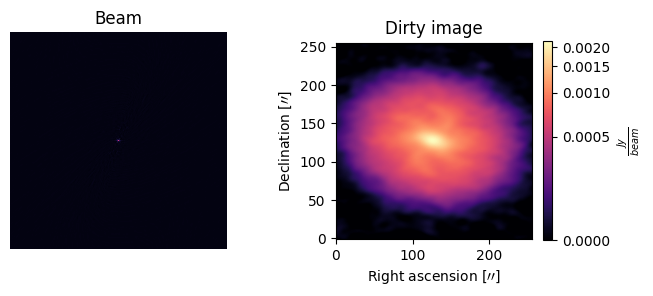

In [4]:
pixel_scale = 0.0017 # arcsec
npix = 4096 # Number of pixels in the grid
coords = coordinates.GridCoords(cell_size=pixel_scale, npix=npix)
img_size = 256 # Number of pixels in the reconstructed image

imager = DirtyImager(
    coords=coords,
    uu=u,
    vv=v,
    weight=weight,
    data_re=vis.real,
    data_im=vis.imag
)

weighting = "briggs"
robust = 0.2
dirty_image, beam = imager.get_dirty_image(weighting = weighting, robust = robust)

dirty_image = dirty_image.squeeze()
beam = beam.squeeze()

pixel_center = npix // 2
U = pixel_center + img_size//2
D = pixel_center - img_size//2
fig, axs = plt.subplots(nrows= 1 , ncols = 2, figsize = (7, 3.5))
axs[0].axis("off")

axs[0].imshow(beam.real, cmap = "magma", origin = "lower")
axs[0].set_title("Beam")

norm = ImageNormalize(dirty_image[..., None, None], vmin = 0, stretch = AsinhStretch())
im = axs[1].imshow((dirty_image)[D:U,D:U].real, cmap =  "magma", norm = norm, origin = "lower")
axs[1].set(title = "Dirty image", xlabel = r"Right ascension $[\prime\prime]$", ylabel = r"Declination $[\prime\prime]$")
plt.colorbar(im, fraction = 0.046, label = r"$\frac{Jy}{beam}$")
plt.subplots_adjust(wspace = 0.5)